## Defining Helping functions for U-net architecture


### Importing libraries

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import Concatenate

### Convolution block :-



In [ ]:
def conv_block(input,num_filters,num_conv):
    """
    Construct a convolutional block with a specified number of convolutional layers.

    Args:
        input (tensorflow.Tensor): The input tensor to the convolutional block.
        num_filters (int): The number of filters in convolutional layer.
        num_conv (int): The total number of convolutional layers in the block.

    Returns:
        tensorflow.Tensor: The output tensor of the convolutional block.
    """
    x = Conv3D(num_filters,3,padding="same",activation = 'relu')(input)
    for i in range(num_conv-1):
        x = Conv3D(num_filters,3,padding="same",activation = 'relu')(x)
    return x


**Encoder block :-**\
Pool Size is fixed :2

In [ ]:
def encoder_block(input,num_filters,num_conv):
    """
    Construct an encoder block, which consists of a convolutional block followed by max pooling.

    Args:
        input (tensorflow.Tensor): The input tensor to the encoder block.
        num_filters (int): The number of filters in the first convolutional layer of the block.
        num_conv (int): The total number of convolutional layers in the block.

    Returns:
        tuple: A tuple containing the output tensor of the convolutional block and the max pooling layer.
    """
    x = conv_block(input,num_filters,num_conv)
    p = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2))(x)

    return x, p


 Decoder block :-

In [ ]:
def decoder_block(input,skip_features,num_filters,num_conv):
  x = UpSampling3D(size = 1)(input)
  x = Conv3DTranspose(num_filters,(2,2,2),strides=2,padding="same")(x)
  x = Concatenate(axis = 4)([skip_features,x])
  x = conv_block(x,num_filters,num_conv)
  return x


In [ ]:
def decoder_block(input, skip_features, num_filters, num_conv):
    """
    Implements a single decoder block operation for convolutional neural networks used in tasks like image segmentation.

    Parameters:
    input (tensor): input tensor to the decoder block
    skip_features (tensor): skip connection features from the corresponding encoder block
    num_filters (int): number of filters to use in the decoder block
    num_conv (int): number of convolutional layers to use in the decoder block

    Returns:
    tensor: output tensor from the decoder block
    """

    # Upsample the input tensor using UpSampling3D layer with size 1
    x = UpSampling3D(size=1)(input)

    # Apply a 3D transposed convolutional layer to x tensor
    # with num_filters filters, kernel size of (2,2,2), stride of 2, and padding set to "same"
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(x)

    # Concatenate skip_features tensor with x tensor along the depth axis
    x = Concatenate(axis=4)([skip_features, x])

    # Apply num_conv convolutional layers with num_filters filters in each layer
    # to the concatenated tensor x using the conv_block function
    x = conv_block(x, num_filters, num_conv)

    # Return the output tensor from the decoder block
    return x


In [ ]:
import math

def PosDown(input_shape):
    """
    Returns the number of times a given input shape can be divided by 2.

    Parameters:
    input_shape (tuple): A tuple of integers representing the input shape.

    Returns:
    int: The number of times the input shape can be divided by 2.
    """
    l = input_shape[0]
    ans = 0

    # Iterate over the log base 2 of the first element of the input shape
    for i in range(int(math.log(l, 2))):
        # Check if the length is even
        if l % 2 == 0:
            ans += 1
            l /= 2
        else:
            # If the length is odd, break out of the loop
            break

    return ans


In [ ]:
#Problems
# 1) Dim error: ValueError: Input 0 of layer sequential_3 is incompatible with the layer: :
# expected min_ndim=4, found ndim=3. Full shape received: [32, 28, 28] --solved
def unet(input_shape,filter_no,no_of_downsamples,num_conv,PosDown):
  inputs = Input(input_shape)
  # encoder part
  s=[]#skipped
  p=[]#passed
  a,b = encoder_block(inputs,filter_no,num_conv)
  s.append(a)
  p.append(b)
  #Is downsampling doable?
  pd=PosDown(input_shape)
  if(pd>no_of_downsamples):
    for i in range(no_of_downsamples-1):
      filter_no *= 2
      a,b = encoder_block(p[i],filter_no,num_conv)
      s.append(a)
      p.append(b)
    filter_no*=2
    # Bridge Part
    b1 = conv_block(p[no_of_downsamples-1],filter_no,num_conv)

    # Decoder part
    b2 = decoder_block(b1,s[no_of_downsamples-1],filter_no,num_conv)
    d = []
    d.append(b2)
    for i in range(no_of_downsamples-1):
      c = decoder_block(d[i],s[no_of_downsamples-i-2],filter_no,num_conv)
      filter_no/=2
      d.append(c)
    outputs = Conv3D(1,1,padding="same",activation="sigmoid")(d[no_of_downsamples-1])
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model
  else:
    print("Downsampling", no_of_downsamples ,"times is not possible since it is only",pd ,"times downsaplable.")

In [ ]:
def unet(input_shape, filter_no, no_of_downsamples, num_conv, PosDown):
    """
    Builds a U-Net model given certain hyperparameters.

    Parameters:
    input_shape (tuple): The shape of the input data.
    filter_no (int): The number of filters for the first layer of the encoder.
    no_of_downsamples (int): The number of times the input data will be downsampled.
    num_conv (int): The number of convolutional layers in each encoder/decoder block.
    PosDown (function): A function that takes the input shape as a parameter and returns the number of times
                        the input data can be divided by 2.

    Returns:
    tf.keras.Model: The U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder part
    s = []  # A list to store the skipped connections
    p = []  # A list to store the passed connections

    # First encoder block
    a, b = encoder_block(inputs, filter_no, num_conv)
    s.append(a)
    p.append(b)

    # Check if downsampling is possible
    pd = PosDown(input_shape)
    if pd > no_of_downsamples:
        for i in range(no_of_downsamples - 1):
            filter_no *= 2
            a, b = encoder_block(p[i], filter_no, num_conv)
            s.append(a)
            p.append(b)

        filter_no *= 2

        # Bridge Part
        b1 = conv_block(p[no_of_downsamples - 1], filter_no, num_conv)

        # Decoder part
        b2 = decoder_block(b1, s[no_of_downsamples - 1], filter_no, num_conv)
        d = []
        d.append(b2)

        for i in range(no_of_downsamples - 1):
            c = decoder_block(d[i], s[no_of_downsamples - i - 2], filter_no, num_conv)
            filter_no /= 2
            d.append(c)

        outputs = Conv3D(1, 1, padding="same", activation="sigmoid")(d[no_of_downsamples - 1])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    else:
        print("Downsampling", no_of_downsamples, "times is not possible since it is only", pd, "times downsaplable.")


In [ ]:
model1 = unet((96,96,96,3),64,6,5,PosDown)

Downsampling 6 times is not possible since it is only 5 times downsaplable.


In [ ]:
model = unet((96,96,96,3),64,4,5,PosDown)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_5 (Conv3D)              (None, 96, 96, 96,   5248        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv3d_6 (Conv3D)              (None, 96, 96, 96,   110656      ['conv3d_5[0][0]']               
                                64)                                                           

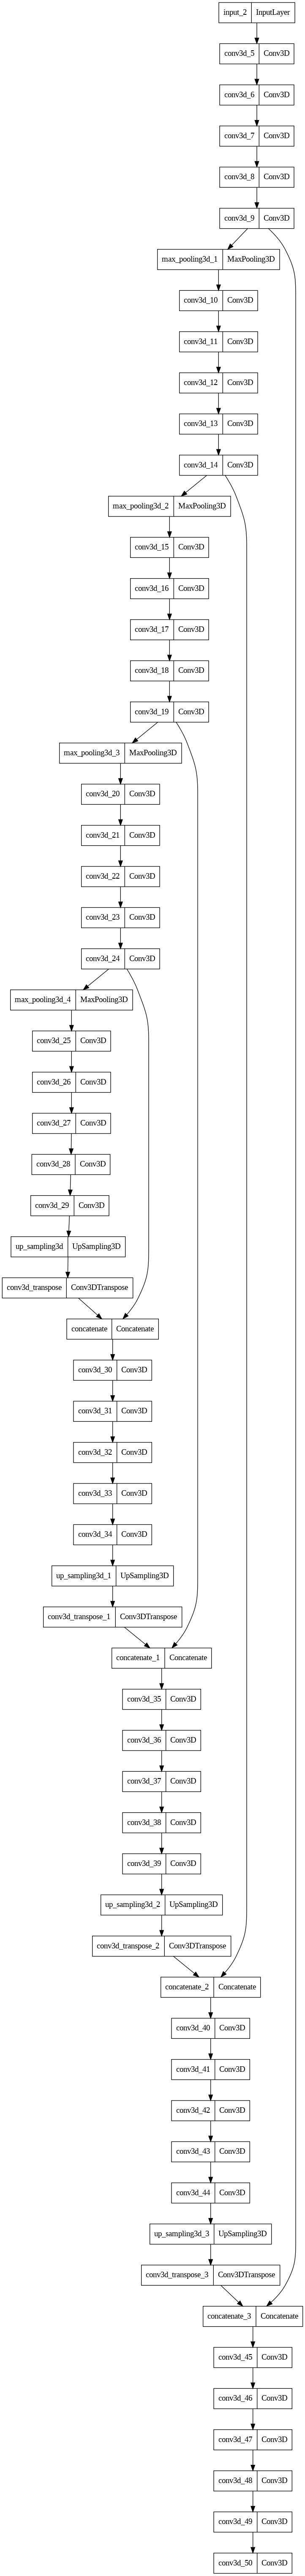

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)